# Descarga de submissions de Reddit mediante el modulo Pushshift usando Python

Para descarga de información en Reddit contamos con muchas herramientas como PRAW, PMAW y requests.

PMAW es derivado de PRAW y ambos tienen algunas limitantes, como la eliminación del   *subreddit.submissions* que nos permite seleccionar la información que será descargada.

Es por esto que se opta por utilizar  *requests* para acceder a Reddit y obtener la información almacenada en **Pushshift**.



# Importar módulos

In [1]:
import pandas as pd # Uso de dataframes
import requests # Método para acceder a Pushshift por mediante url 
import json # Manipulación de información JSON
import csv # Para convertir las tablas finales en archivos csv y guardarla en la máquina local
import time # Convertir el tiempo UTC en tiempo GMT
import datetime # Manipulación del tiempo

# Ejemplos de URLS de Pushshift

In [2]:
# Se puede acceder al API de Pushshift a través de una URL con los parámetros relevantes sin necesidad de identificarse en Reddit
# Estos son algunos ejemplos de URLs que generan una página con información JSON
busca_gaming_despues_fecha = "https://api.pushshift.io/reddit/search/submission/?q=screenshot&after=1514764800&before=1517443200&subreddit=gaming"
busca_science = "https://api.pushshift.io/reddit/search/submission/?q=science"

# Parámetros para el URL de Pushshift
Estos son los parámetros que se conideran más importantes para la consulta de Reddit, utilizados para la construcción del URL de Pushshift:

* size — Tamaño de entradas devueltas, modificado a 1,000
* after — Dónde comienza la búsqueda 
* before — Dónde finaliza la búsqueda
* title — Busca submissions que contengan la palabra en el título
* subreddit — Busca en un Subreddit en particular

Todo esto con la finalidad de reducir el tamaño de la búsqueda.

In [3]:
# Adaptado de https://gist.github.com/dylankilkenny/3dbf6123527260165f8c5c3bc3ee331b
# Se construye la URL de Pushshift, accediendo a una pagina web donde está almacenada la información en JSON a manera de lista
def getPushshiftData(query, after, before, sub):
    # Construye la URL de Pushshift con los parámetros antes mencionados
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    # Muestra al usuario la URL 
    print(url)
    # Solicitud de la URL
    r = requests.get(url)
    # Carga la pagina con la información JSON en una variable
    data = json.loads(r.text, strict=False)
    #regresa la información de la variable donde está contenida
    return data['data']

# Extrae la información clave de Submissions

Es aquí donde tenemos la libertad de solicitar la información que requerimos de Submissions para nuestro análisis: 
* Title: Título de la noticia
* URL: URL de la noticia
* Subreddit: Grupo en el que se publicó el submission
* Selftext: Contenido de la noticia, no todas las noticiac cuentan con esto
* Flair: Tópico del submission
* Author: Usuario que publicó el submission
* ID: ID para identificar el submission
* Score: Puntuación del submission
* Created_utc: Fecha de publicación
* Num_comments: Número de comentarios 
* Permalink: Enlace permanente.


In [4]:
# Extracción de la información específica de los datos JSON generados  
def collectSubData(subm):
    #subData fue creado al inicio donde está toda la información para ser agregados a la variable global subStats.
    subData = list() # lista para almacenar la información
    title = subm['title'] # Titulo 
    url = subm['url'] # URL
    subreddit = subm['subreddit'] # Grupo Subreddit
    # selftext, o cuerpo del post, no siempre está presente en submissions, para evitar errores se usa try/except
    try:
      body = subm['selftext']
    except KeyError:
      body = ''
    #flairs no siempre está presente en submissions, para evitar errores se usa try/except
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"    
    author = subm['author'] # Autor del post
    sub_id = subm['id'] # ID del post
    score = subm['score'] # Puntuación del post
    created = datetime.datetime.fromtimestamp(subm['created_utc']) # Fecha de creación en UTC, por lo que se hace la conversión
    numComms = subm['num_comments'] # Número de comentarios
    permalink = subm['permalink'] # Linl permanente

    #Junta toda la información en una tubla y se agrega a subData
    subData.append((sub_id,title,url,subreddit,body,author,score,created,numComms,permalink,flair))
    # Crea un diccionario con la entrada de información del submission actual y almacena toda la información relacionada con el submission
    subStats[sub_id] = subData

# Actualiza los parámetros de búsqueda

In [5]:
# Para tener el formato correcto de tiempo de la URL se puede usar la siguiente página
#https://www.unixtimestamp.com/index.php > Esto para crear el propio timestamp
after = "1608310800" #Submissions despues del timestamp
before = "1609459200" #Submissions antes del timestamp
query = "" # Palabra clave para buscar en submissions
sub = "wallstreetbets" #Cual Subreddit se buscará la información

#subCount cuenta el no. del total de envíos que se recopila
subCount = 0
#subStats es el diccionario donde almacenaremos nuestros datos.
subStats = {}

In [6]:
# Necesitamos ejecutar esta función fuera del ciclo primero para obtener después la variable actualizada
data = getPushshiftData(query, after, before, sub)
# Se ejecutará hasta que se hayan recopilado todas las publicaciones, es decir, cuando la longitud de la variable de datos = 0
# desde la fecha 'posterior' hasta la fecha 'anterior'
while len(data) > 0: #La longitud de los datos es el número de submission(data[0],data[1], etc.), una vez que llega a cero (después y antes de que vars sean iguales) finaliza
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Llama getPushshiftData() Con la fecha creada del ultimo submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    #actualiza la variable 'after' a la última fecha creada del submission
    after = data[-1]['created_utc']
    # datos han cambiado debido a la nueva variable posterior proporcionada por el código anterior
    data = getPushshiftData(query, after, before, sub)
    
print(len(data))

https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608310800&before=1609459200&subreddit=wallstreetbets
100
2020-12-18 17:59:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608314367&before=1609459200&subreddit=wallstreetbets
100
2020-12-18 19:27:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608319631&before=1609459200&subreddit=wallstreetbets
97
2020-12-18 20:43:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608324230&before=1609459200&subreddit=wallstreetbets
100
2020-12-18 21:38:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608327507&before=1609459200&subreddit=wallstreetbets
100
2020-12-18 22:57:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608332273&before=1609459200&subreddit=wallstreetbets
100
2020-12-19 00:54:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1608339281&befo

# Revisión de que la extracción del submission se haya cumplido con exito

In [7]:
print(str(len(subStats)) + " submissions agregado a la lista")
print("1st entrada es:")
print(list(subStats.values())[0][0][1] + " creado por: " + str(list(subStats.values())[0][0][5]))
print("Ultima entrada es:")
print(list(subStats.values())[-1][0][1] + " creado por: " + str(list(subStats.values())[-1][0][5]))

12432 submissions agregado a la lista
1st entrada es:
Riding PLTR to the moon! creado por: Dude1342
Ultima entrada es:
Fuck bills! all in GME calls creado por: Watertuner_51


# Guardado de información en archivo CSV

In [8]:
def updateSubs_file():
    upload_count = 0
    print("Ingresa el nombre del archivo agregando .csv al final ")
    filename = input() #Nombre que puso al archivo csv
    file = filename
    with open(file, 'w', newline='', encoding='utf-8') as file: 
        a = csv.writer(file, delimiter=',')
        headers = ["Post ID","Title","Url","Subreddit","Body","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"]
        a.writerow(headers)
        for sub in subStats:
            a.writerow(subStats[sub][0])
            upload_count+=1
            
        print(str(upload_count) + " submissions han sido guardados en un archivo csv")
updateSubs_file()

Ingresa el nombre del archivo agregando .csv al final 
TEST.csv
12432 submissions han sido guardados en un archivo csv


In [9]:
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [10]:
data = pd.read_csv("TEST.csv")

In [14]:
data.head(10)

,Post ID,Title,Url,Subreddit,Body,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,kfox19,Riding PLTR to the moon!,https://i.redd.it/4n8ihki88z561.jpg,wallstreetbets,NaN,Dude1342,1,2020-12-18 17:00:04,0,/r/wallstreetbets/comments/kfox19/riding_pltr_...,Meme
1,kfoygx,Wtf is up w MT???,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,[removed],MilesOfKings,1,2020-12-18 17:01:48,0,/r/wallstreetbets/comments/kfoygx/wtf_is_up_w_mt/,Stocks
2,kfoz1p,$20 LAZR long term call spread for $3,https://i.redd.it/vpfq9nwo8z561.jpg,wallstreetbets,NaN,MannerThink,8,2020-12-18 17:02:37,6,/r/wallstreetbets/comments/kfoz1p/20_lazr_long...,Options
3,kfoz45,Bb is going doooown,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,[removed],The_real_slim_pedro,1,2020-12-18 17:02:42,0,/r/wallstreetbets/comments/kfoz45/bb_is_going_...,NaN
4,kfozmb,2021: Time to Juggle your Investments?,https://www.matthewfeargrieve.org/post/matthew...,wallstreetbets,NaN,matthewfeargrieve,1,2020-12-18 17:03:21,0,/r/wallstreetbets/comments/kfozmb/2021_time_to...,Discussion
5,kfozn5,How to get out of car lease?!,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,[removed],Nightmare4298,1,2020-12-18 17:03:23,0,/r/wallstreetbets/comments/kfozn5/how_to_get_o...,Discussion
6,kfozrz,Crowdstrike,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,[removed],boiseairguard,4,2020-12-18 17:03:33,4,/r/wallstreetbets/comments/kfozrz/crowdstrike/,YOLO
7,kfp00x,🍻 u/rbriggs4 for posting DD on a buzz word-hyp...,https://i.redd.it/zi7bmn2x8z561.jpg,wallstreetbets,NaN,TheDreaded3Putt,28,2020-12-18 17:03:53,12,/r/wallstreetbets/comments/kfp00x/urbriggs4_fo...,Options
8,kfp03u,Made it to the 1% club,https://i.redd.it/chuerklx8z561.png,wallstreetbets,NaN,motleyboyer,1,2020-12-18 17:04:00,0,/r/wallstreetbets/comments/kfp03u/made_it_to_t...,Shitpost
9,kfp0jh,$LEMONADE is going to be WSB next meme stock 🍋,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,[removed],Memestockrider,1,2020-12-18 17:04:32,0,/r/wallstreetbets/comments/kfp0jh/lemonade_is_...,Meme


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12432 entries, 0 to 12431
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Post ID                12432 non-null  object
 1   Title                  12432 non-null  object
 2   Url                    12432 non-null  object
 3   Subreddit              12432 non-null  object
 4   Body                   5406 non-null   object
 5   Author                 12432 non-null  object
 6   Score                  12432 non-null  int64 
 7   Publish Date           12432 non-null  object
 8   Total No. of Comments  12432 non-null  int64 
 9   Permalink              12432 non-null  object
 10  Flair                  12045 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [16]:
data.describe()

,Score,Total No. of Comments
count,12432.000000,12432.000000
mean,2.887548,56.112452
std,61.638879,1014.282596
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,11.000000
max,4708.000000,50374.000000


In [18]:
print(data.groupby(['Title']).size().sort_values())

Title
" Don't take profits off the table. Double down, on margin. Borrow everything you can. Stonks never go down!" Chris Sacca      1
Ran out of Salt, so i just searched TSLA on google                                                                             1
Random 2021 predictions I came across.                                                                                         1
Random promoted hentai on twitter. Dude wastes girls money on stonks. Looses it all. Should have waited for pull back bro.     1
Rare interview with Andrew Left                                                                                                1
                                                                                                                              ..
Merry Christmas                                                                                                                9
Difference                                                                                 

In [19]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [20]:
from collections import Counter
data_title = data['Title'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data_title for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,2908
1,to,2838
2,I,1813
3,a,1768
4,and,1405
5,on,1321
6,is,1291
7,in,1264
8,for,1241
9,of,1209


In [21]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Palabras comunes en el texto', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [22]:
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import warnings
warnings.simplefilter("ignore")

def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "fuck", "fucking"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

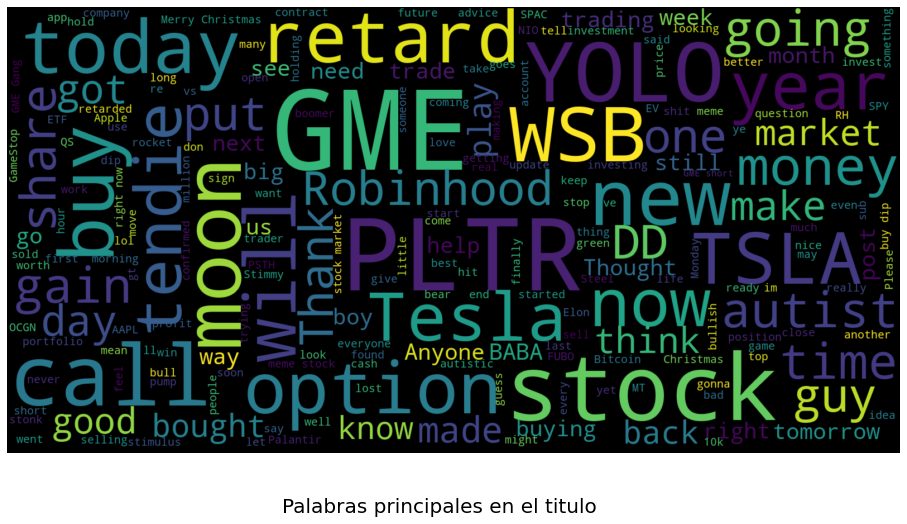

In [24]:
show_wordcloud(data['Title'], title = 'Palabras principales en el titulo')

In [25]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [26]:
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"     

In [29]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='green')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Contador : {title} sentimientos', size=12)
    ax2.set_ylabel(f'Porcentaje : {title} sentimientos', size=12)
    plt.suptitle(f"Analisis de sentimiento: {title}")
    plt.tight_layout()
    plt.show()

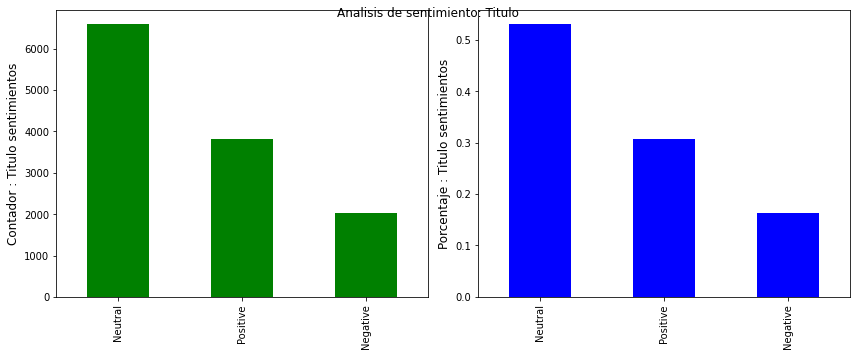

In [30]:
data['title_sentiment'] = data['Title'].apply(lambda x: find_sentiment(x))
plot_sentiment(data, 'title_sentiment', 'Titulo')

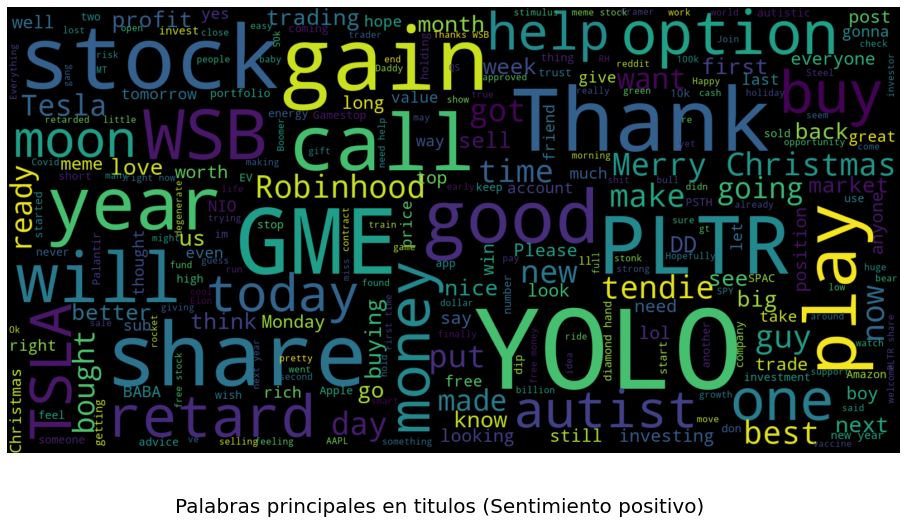

In [32]:
show_wordcloud(data.loc[data['title_sentiment']=='Positive', 'Title'], title = 'Palabras principales en titulos (Sentimiento positivo)')

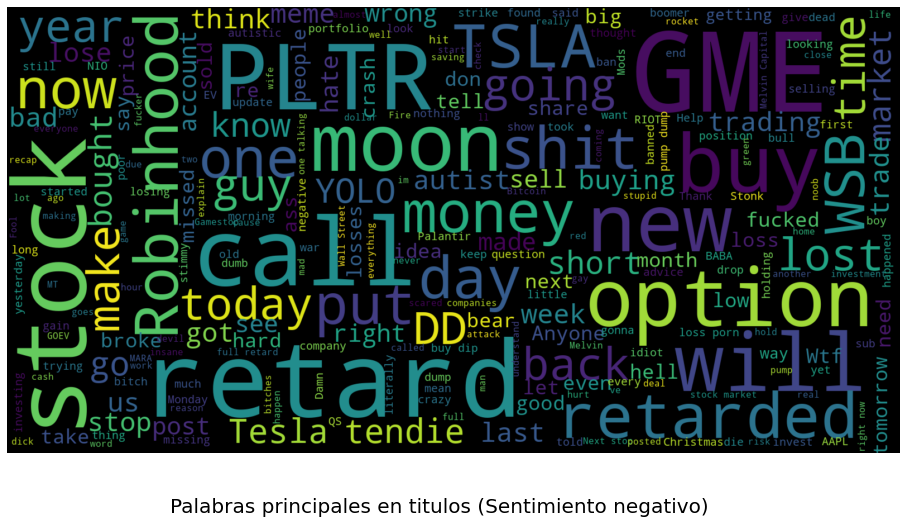

In [34]:
show_wordcloud(data.loc[data['title_sentiment']=='Negative', 'Title'], title = 'Palabras principales en titulos (Sentimiento negativo)')